<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/NN%20ECG%20LSTM%20CNN%20Attention%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/polomarco/ecg-classification-cnn-lstm-attention-mechanism/input?select=mitbih_with_syntetic_test.csv

In [1]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

https://www.physionet.org/content/mitdb/1.0.0/

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path_train = '/content/drive/MyDrive/edf_process/mitbih_train.csv'
file_path_test = '/content/drive/MyDrive/edf_process/mitbih_test.csv'

Mounted at /content/drive


In [3]:
import random

n = 100000 #number of records in file
s = 10000 #desired sample size
skip = sorted(random.sample(range(n),n-s))

In [4]:
df_mitbih_train = pd.read_csv(file_path_train, header=None, skiprows=skip)
df_mitbih_test = pd.read_csv(file_path_test, header=None, skiprows=skip)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)


In [5]:
df_mitbih.rename(columns={187: 'class'}, inplace=True)

df_mitbih_test.rename(columns={187: 'class'}, inplace=True)
df_mitbih_train.rename(columns={187: 'class'}, inplace=True)

In [6]:
id_to_label = {
    0: "Normal",     #0: "Нормальный"
    1: "Artial Premature", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Premature ventricular contraction", # "Преждевременное сокращение желудочков"
    3: "Fusion of ventricular and normal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Fusion of paced and normal" #"Cлияние стимулированного и нормального ритма"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
df_mitbih_test['label'] = df_mitbih_test.iloc[:, -1].map(id_to_label)
df_mitbih_train['label'] = df_mitbih_train.iloc[:, -1].map(id_to_label)


print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10946 entries, 0 to 2187
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 15.9+ MB
None


In [7]:
df_mitbih_train.head()

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,class,label
0,1.0,0.558767,0.173410,0.192678,0.113680,0.005780,0.015414,0.104046,0.200385,0.256262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,1.0,0.819444,0.157407,0.240741,0.222222,0.217593,0.208333,0.212963,0.226852,0.222222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,1.0,0.477612,0.000000,0.123134,0.164179,0.089552,0.070896,0.082090,0.074627,0.063433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,1.0,0.747934,0.528926,0.252066,0.099174,0.090909,0.157025,0.181818,0.185950,0.202479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,1.0,0.913934,0.717213,0.524590,0.319672,0.168033,0.127049,0.151639,0.155738,0.143443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


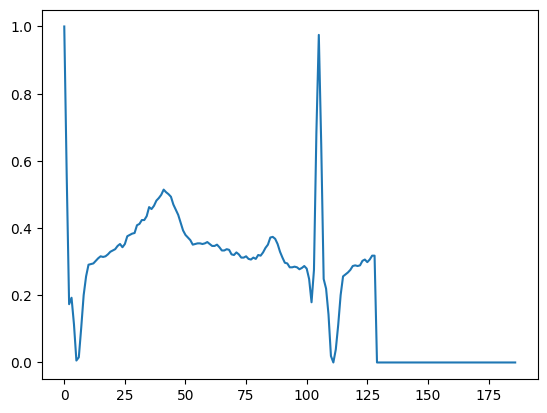

In [99]:
plt.plot(df_mitbih_train.iloc[0][:-2])

In [8]:
df_mitbih['label'].value_counts()

,count
label,
Normal,9094
Fusion of paced and normal,776
Premature ventricular contraction,715
Artial Premature,289
Fusion of ventricular and normal,72


In [9]:
check_nan = df_mitbih[:].isnull().values.any()
print(check_nan)

False


In [10]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [11]:
#def get_dataloader(df, phase: str, batch_size: int = 96) -> DataLoader:
def get_dataloader(df, phase: str, batch_size: int = 96):

    '''
    Dataset and DataLoader.
    Parameters:
        pahse: training or validation phase.
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    #df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=123, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4)
    return dataloader

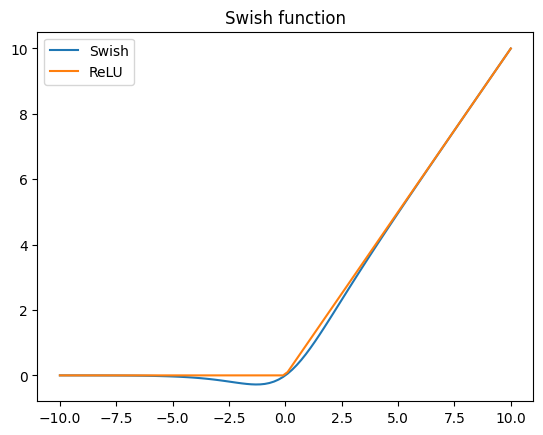

In [12]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

# NN Models

In [13]:
class RNN(nn.Module):
    """RNN module(cell type lstm or gru)"""
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p = 0.2,
        bidirectional = False,
        rnn_type = 'lstm',
    ):
        super().__init__()

        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [57]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 5,
    ):

        super().__init__()

        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size//4, out_features=num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

In [14]:
class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [15]:
class RNNModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,#hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)#.squeeze(1)
        return x

In [16]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [17]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion

In [18]:
class Trainer:
    def __init__(self, df, net, lr, batch_size, num_epochs):
        #self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        #self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.optimizer = AdamW(net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(df, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase, net):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        #self.net.train() if phase == 'train' else self.net.eval()
        net.train() if phase == 'train' else net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            target = target.to(device)
            #data = data.to(config.device)
            #target = target.to(config.device)

            #output = self.net(data)
            output = net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())

        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self, net):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train',net=net)
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val',net=net)
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                #torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
                torch.save(net.state_dict(), f"best_model_epoc{epoch}.pth")
            #clear_output()


# Modeling

In [58]:
#model = RNNAttentionModel(1, 64, 'lstm', bidirectional=False)
#model = RNNModel(input_size=1, hid_size=64, rnn_type='lstm', bidirectional=True)
model = CNN(num_classes=5, hid_size=64)

In [59]:
model._modules.items()
#model.state_dict()

dict_items([('conv1', ConvNormPool(
  (conv_1): Conv1d(1, 64, kernel_size=(5,), stride=(1,))
  (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (conv_3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
  (swish_1): Swish()
  (swish_2): Swish()
  (swish_3): Swish()
  (normalization_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)), ('conv2', ConvNormPool(
  (conv_1): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
  (conv_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (conv_3): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (swish_1): Swish()
  (swish_2): Swish()
  (swish_3): Swish()
  (normalization_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, 

In [60]:
trainer = Trainer(df=df_mitbih, net=model, lr=1e-3, batch_size=32, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train mode | time: 19:23:39


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.1827356537868237, accuracy: 0.8210847701149425, f1: 0.45431216035852207, precision: 0.5572431573397912, recall: 0.8087473952121091


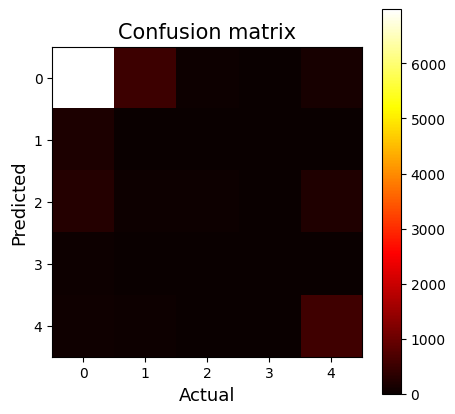

val mode | time: 19:24:25


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.0250226563098384, accuracy: 0.9392156862745098, f1: 0.6708871638312263, precision: 0.663193536673929, recall: 0.9819600952644659


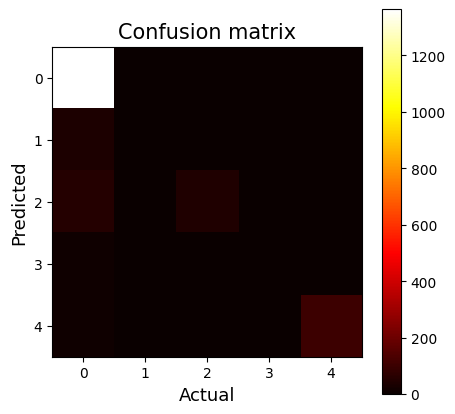


New checkpoint

train mode | time: 19:24:32


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9921021821170017, accuracy: 0.9367097701149425, f1: 0.6820952841166389, precision: 0.6936976141591931, recall: 0.9483587950676338


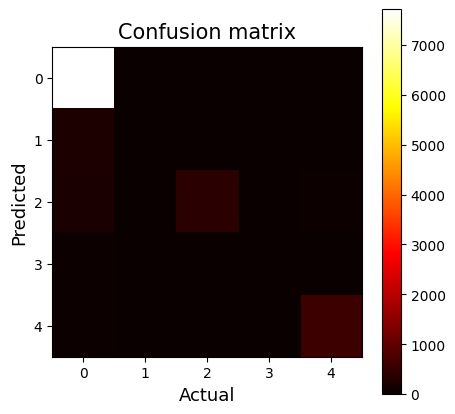

val mode | time: 19:25:16


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.0081616102480422, accuracy: 0.9453431372549019, f1: 0.6945290795863572, precision: 0.7319894404248134, recall: 0.9100013669430043


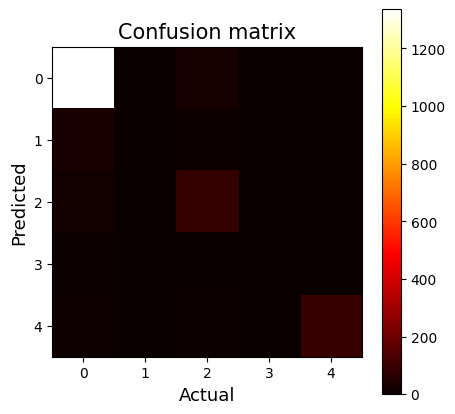


New checkpoint

train mode | time: 19:25:23


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9706833794199187, accuracy: 0.9482399425287356, f1: 0.7292937908776747, precision: 0.740360037889706, recall: 0.9578803465263871


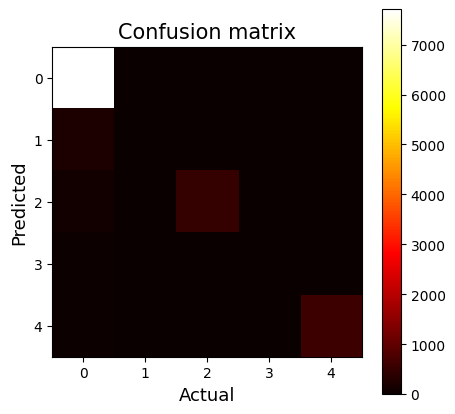

val mode | time: 19:26:06


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9831799046666014, accuracy: 0.9637254901960784, f1: 0.7504715745074841, precision: 0.760357367466792, recall: 0.96719845560305


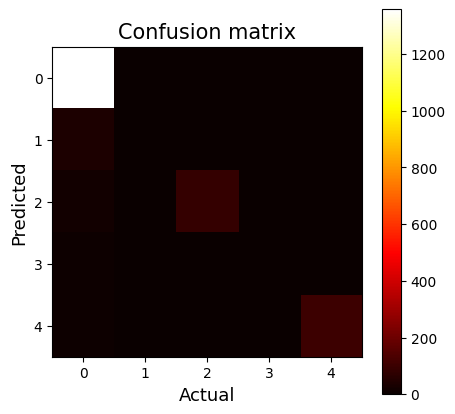


New checkpoint

train mode | time: 19:26:10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9620932515325218, accuracy: 0.9542025862068966, f1: 0.7436267987619549, precision: 0.7618715309944755, recall: 0.9543258154388989


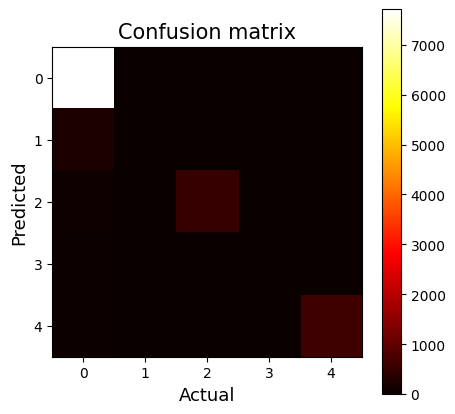

val mode | time: 19:27:00


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9821613010238198, accuracy: 0.9643382352941177, f1: 0.7458040039502745, precision: 0.7685801503684119, recall: 0.9540254863088511


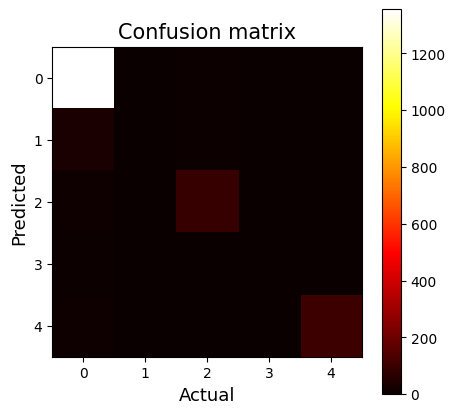


New checkpoint

train mode | time: 19:27:03


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9577207573528947, accuracy: 0.9571120689655173, f1: 0.7542211671561277, precision: 0.7709305148293651, recall: 0.9615319050441622


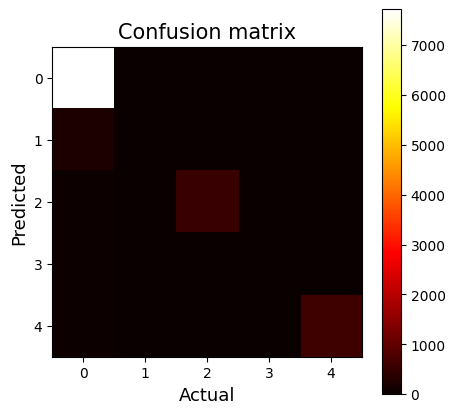

val mode | time: 19:27:47


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9777208216050092, accuracy: 0.9661764705882353, f1: 0.7615055994616476, precision: 0.7687970396319542, recall: 0.9722252791349119


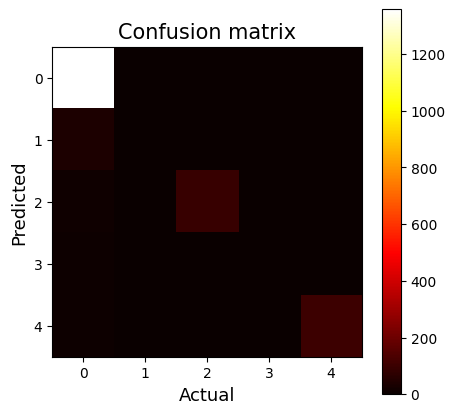

train mode | time: 19:27:50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.952946058635054, accuracy: 0.9612068965517241, f1: 0.7721372164391385, precision: 0.7849751115137552, recall: 0.9677080916719246


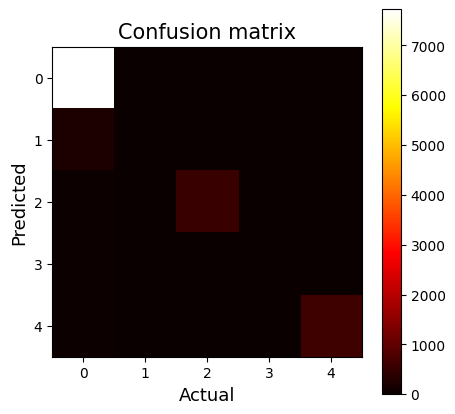

val mode | time: 19:28:32


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9735790280734792, accuracy: 0.9704656862745098, f1: 0.7874192373971918, precision: 0.789466974272477, recall: 0.9802183963149798


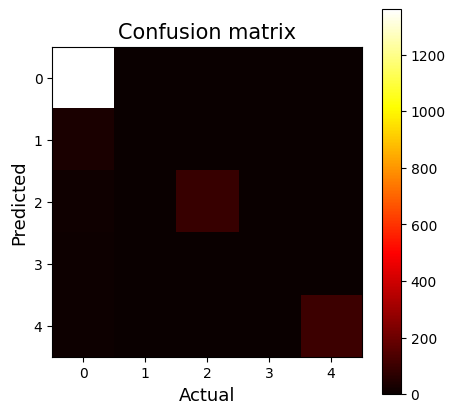


New checkpoint

train mode | time: 19:28:38


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9490248951418646, accuracy: 0.9662715517241379, f1: 0.7952476347365107, precision: 0.8083970508360117, recall: 0.9694920977290663


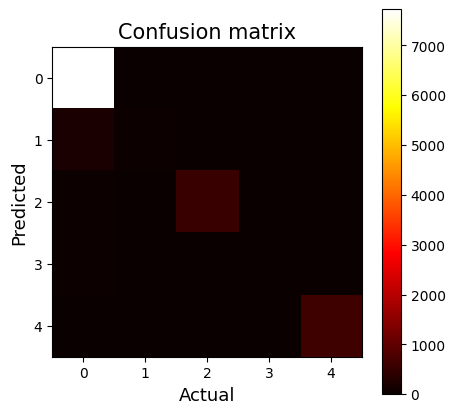

val mode | time: 19:29:23


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9714868723177442, accuracy: 0.9772058823529411, f1: 0.820460904067152, precision: 0.8315883042859639, recall: 0.9733178334845971


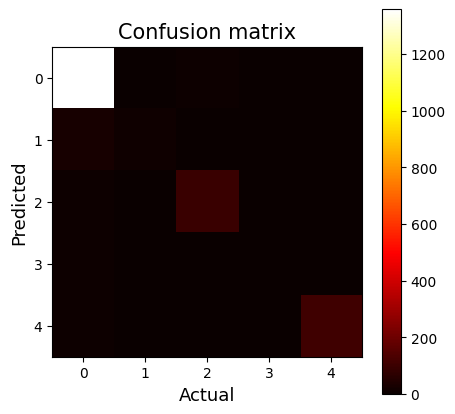


New checkpoint

train mode | time: 19:29:27


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9458681394313944, accuracy: 0.9710129310344827, f1: 0.8180800395766286, precision: 0.8306676952984912, recall: 0.9733694741210165


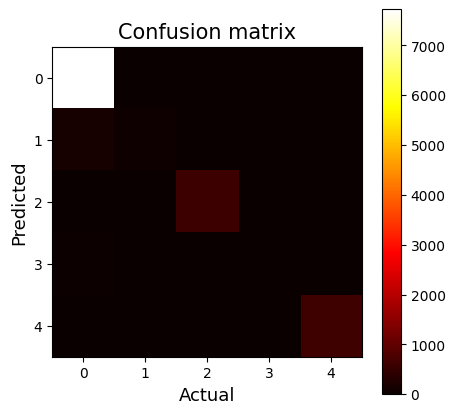

val mode | time: 19:30:11


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9718663037991991, accuracy: 0.9765931372549019, f1: 0.8337305429240099, precision: 0.8364814467281261, recall: 0.9817989281800223


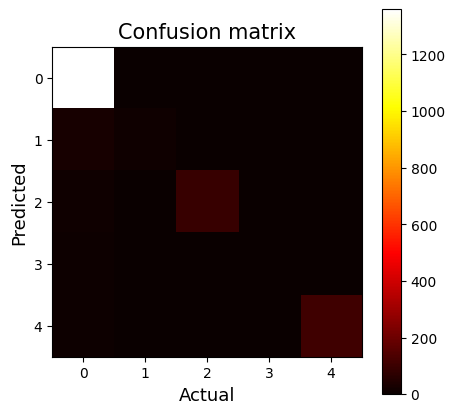

train mode | time: 19:30:14


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9436936964248789, accuracy: 0.9737068965517242, f1: 0.8345729003023483, precision: 0.8469847451069206, recall: 0.9747703334453977


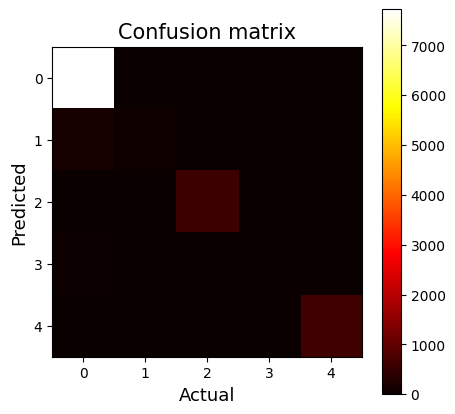

val mode | time: 19:31:15


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9694993098576864, accuracy: 0.9778186274509804, f1: 0.8339533694378054, precision: 0.8360029219848955, recall: 0.9858736357706437


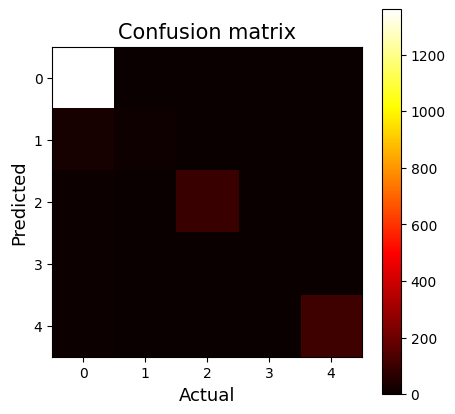

train mode | time: 19:31:21


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9426484438879736, accuracy: 0.9751077586206897, f1: 0.8429937741383442, precision: 0.8521351943076074, recall: 0.9788424338060605


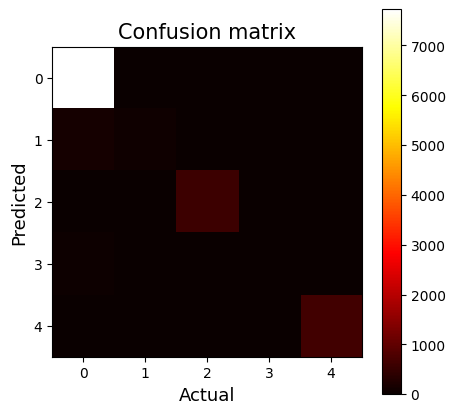

val mode | time: 19:32:03


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 0.9684429975116954, accuracy: 0.9790441176470588, f1: 0.8372268120302673, precision: 0.8427658123262173, recall: 0.9835228231595201


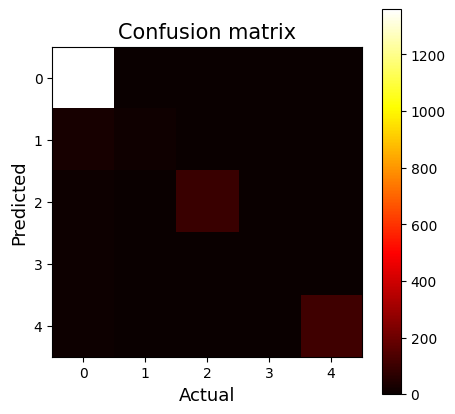

In [61]:
trainer.run(net=model)

In [62]:
model.eval()

CNN(
  (conv1): ConvNormPool(
    (conv_1): Conv1d(1, 64, kernel_size=(5,), stride=(1,))
    (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (conv_3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (swish_1): Swish()
    (swish_2): Swish()
    (swish_3): Swish()
    (normalization_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (normalization_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (normalization_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvNormPool(
    (conv_1): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
    (conv_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (conv_3): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (swish_1): Swish()
    (swish_2): Swish()
    (swish_3): Swish()
    (normalization_1): BatchNorm1d(32, eps=1e-05

In [63]:
train_logs = trainer.train_df_logs
train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

logs = pd.concat([train_logs,val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss',
    'train_accuracy', 'val_accuracy',
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
                                 ]
logs.head()

,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall
0,1.182736,1.025023,0.821085,0.939216,0.454312,0.670887,0.557243,0.663194,0.808747,0.981960
1,0.992102,1.008162,0.936710,0.945343,0.682095,0.694529,0.693698,0.731989,0.948359,0.910001
2,0.970683,0.983180,0.948240,0.963725,0.729294,0.750472,0.740360,0.760357,0.957880,0.967198
3,0.962093,0.982161,0.954203,0.964338,0.743627,0.745804,0.761872,0.768580,0.954326,0.954025
4,0.957721,0.977721,0.957112,0.966176,0.754221,0.761506,0.770931,0.768797,0.961532,0.972225


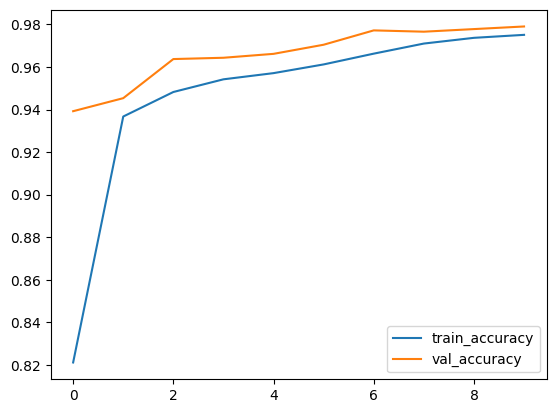

In [73]:
plt.plot(logs["train_accuracy"], label='train_accuracy')
plt.plot(logs["val_accuracy"], label='val_accuracy' )
plt.legend()
plt.show()

In [74]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [75]:
test_dataset = ECGDataset(df_mitbih_test)
print(df_mitbih_test.shape)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, num_workers=0, shuffle=False)

(2188, 189)


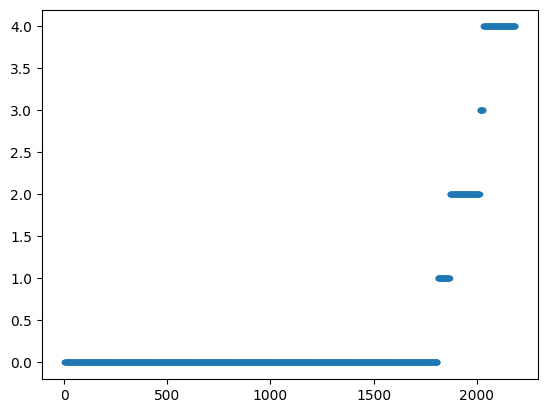

In [77]:
plt.plot(test_dataset[:][1],'.')

In [78]:
#models = [cnn_model, lstm_model, attn_model]
models = [model]

In [79]:
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

((2188,), (2188,))

In [80]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


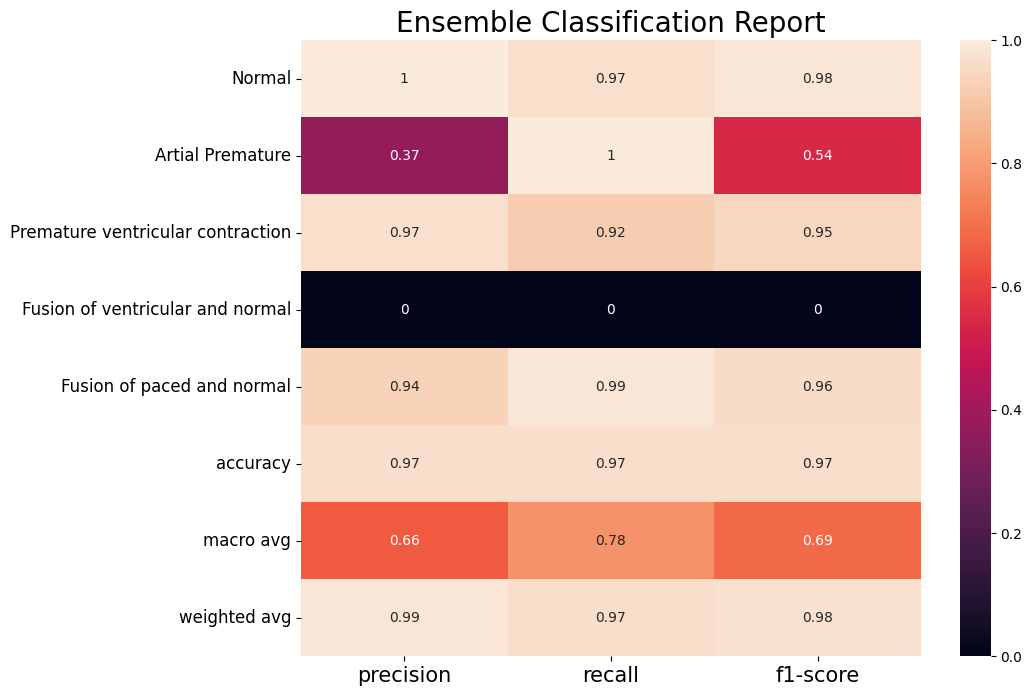

In [83]:
clf_report = classification_report(y_pred,
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),
                                   output_dict=True)


plt.figure(figsize=(10, 8))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("Ensemble Classification Report", fontsize=20)
plt.savefig(f"ensemble result.svg",format="svg",bbox_inches='tight', pad_inches=0.2)
plt.savefig(f"ensemble result.png", format="png",bbox_inches='tight', pad_inches=0.2)